<a href="https://colab.research.google.com/github/dinhngoc267/exploratory_data_analysis/blob/main/articles_recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip  /content/drive/MyDrive/OneDrive_1_6-26-2023.zip -d '/content/'

Archive:  /content/drive/MyDrive/OneDrive_1_6-26-2023.zip
 extracting: /content/articles.csv.gz  
 extracting: /content/reading.csv.gz  
 extracting: /content/users.csv.gz   


### Import Lib

In [1]:
!pip install -q underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 53.4 MB/s eta 0:00:00


In [ ]:
!pip install -q wordcloud

In [2]:
import pandas as pd
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
from underthesea import word_tokenize
import datetime
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px


### Load Data

In [6]:
with gzip.open('/content/articles.csv.gz') as f:
    articles_df = pd.read_csv(f)
articles_df.head()

,article_id,published_time,title,domain,category
0,280665035534066165,2022-04-13 15:22:08,"Đổ xăng xong nhưng bùng tiền, tài xế méo mặt k...",giadinh.net.vn,Đời sống
1,553165162239741497,2022-04-08 04:40:00,"Sài Gòn: Chán màu xanh dương, Mercedes-AMG G63...",xehay.vn,Xe
2,4936028575939004693,2022-04-08 08:25:00,"Khai mạc Kỳ họp thứ Tư, HĐND thành phố Hà Nội ...",kinhtedothi.vn,Xã hội
3,5371965639343924869,2022-04-12 15:07:43,Lão nông đào được viên đá lạ đem bán 2000 đồng...,giadinh.net.vn,Khoa học
4,6042543455069651737,2022-04-11 07:14:34,Cưu mang chú chó 3 chân không ngờ chú chó cứu ...,giadinh.net.vn,Đời sống


In [7]:
with gzip.open('/content/reading.csv.gz') as f:
    reading_df = pd.read_csv(f)
reading_df.head()

,user_id,article_id,event_time
0,13214459406561935989,14810025847983156880,2022-04-06 00:00:00
1,1289026229861087090,17510905596044558175,2022-04-06 00:00:00
2,3001758567334363234,9741355532714246116,2022-04-06 00:00:00
3,9935763984618015567,7546671372785216919,2022-04-06 00:00:00
4,10238108363219256632,13307914094188214671,2022-04-06 00:00:01


In [8]:
with gzip.open('/content/users.csv.gz') as f:
    users_df = pd.read_csv(f)
users_df.head()

,user_id,gender,age,os_name
0,4716260340891938377,Female,<18,windows
1,15290165232401343976,Male,<18,windows
2,13521408200001072707,Female,<18,windows
3,12660877307552158199,Female,<18,windows
4,13273334199460270956,Female,<18,windows


### EDA

#### Articles

In [9]:
articles_df.shape

(84066, 5)

In [10]:
articles_df.nunique(axis=0)

article_id        84066
published_time    51246
title             84017
domain              150
category             14
dtype: int64

In [11]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84066 entries, 0 to 84065
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   article_id      84066 non-null  uint64
 1   published_time  84066 non-null  object
 2   title           84066 non-null  object
 3   domain          84066 non-null  object
 4   category        84066 non-null  object
dtypes: object(4), uint64(1)
memory usage: 3.2+ MB


In [12]:
articles_df['published_time'] = pd.to_datetime(articles_df['published_time'], format= "%Y-%m-%d %H:%M:%S")

> There is no missing value and all the features in `articles_df` are categorical

In [13]:
print(articles_df['published_time'].min())
print(articles_df['published_time'].max())

2022-04-03 00:00:00
2022-04-13 23:59:13


> The dataset is extracted from 03-04 to 13-4

> The articles come from 150 domains.

##### **Which domain have the most publications?**

In [14]:
articles_df['domain'].value_counts()

vietgiaitri.com        4559
toquoc.vn              4278
thanhnien.vn           2874
vnexpress.net          2757
vtv.vn                 2580
                       ... 
tapchiqptd.vn             9
plo.vn                    7
congnghe.tuoitre.vn       6
guu.vn                    4
baodansinh.vn             1
Name: domain, Length: 150, dtype: int64

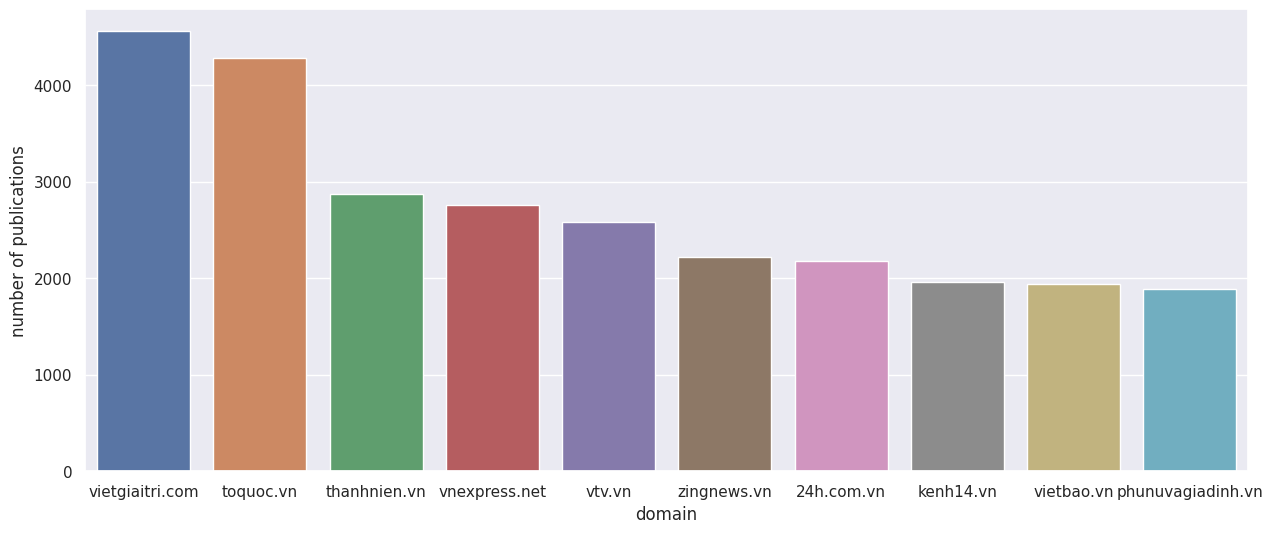

In [15]:
domain_group = articles_df.groupby(['domain']).agg({"article_id": "count"}).reset_index().rename(columns={"article_id": "count"}).sort_values(by=['count'], ascending=False)

sns.set(rc={'figure.figsize':(15,6)})

p = sns.barplot(data=domain_group[:10], x='domain', y='count')
p.set(xlabel= "domain", ylabel="number of publications")
plt.show()

> **`vietgiaitri.com` ; `toquoc.vn` ; `thanhnien.vn` are top domains have most publications**

##### **Which category has the most publications?**

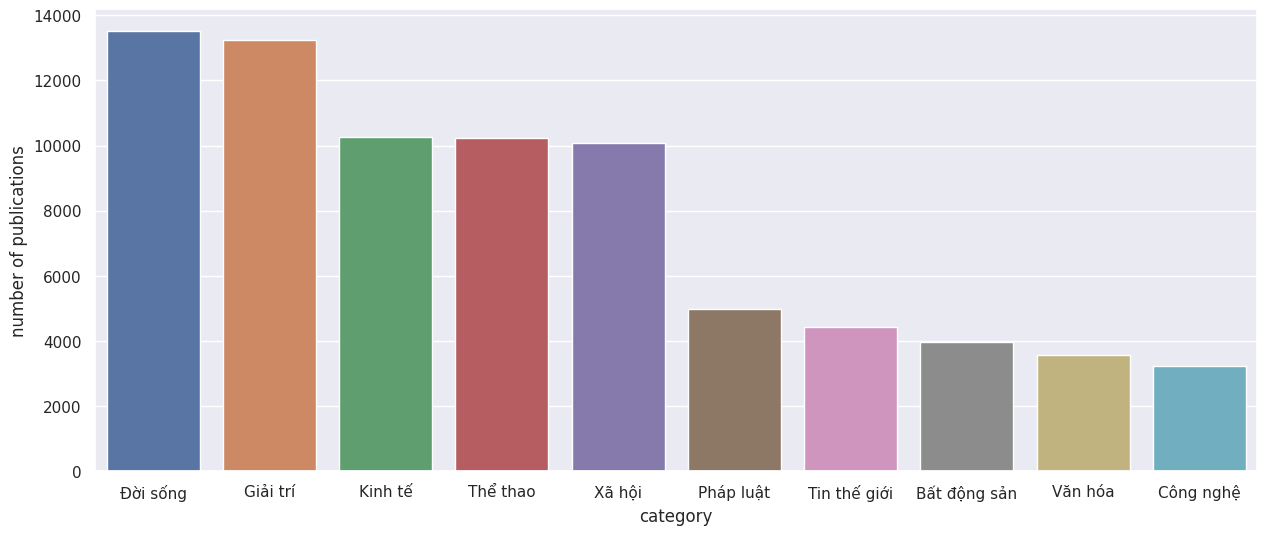

In [16]:
cat_group = articles_df.groupby(['category']).agg({"article_id": "count"}).reset_index().rename(columns={"article_id": "count"}).sort_values(by=['count'], ascending=False)
sns.set(rc={'figure.figsize':(15,6)})

p = sns.barplot(data=cat_group[:10], x='category', y='count')
p.set(xlabel= "category", ylabel="number of publications")
plt.show()

#### Users

In [17]:
users_df.head()

,user_id,gender,age,os_name
0,4716260340891938377,Female,<18,windows
1,15290165232401343976,Male,<18,windows
2,13521408200001072707,Female,<18,windows
3,12660877307552158199,Female,<18,windows
4,13273334199460270956,Female,<18,windows


In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179523 entries, 0 to 179522
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  179523 non-null  uint64
 1   gender   179523 non-null  object
 2   age      179523 non-null  object
 3   os_name  179523 non-null  object
dtypes: object(3), uint64(1)
memory usage: 5.5+ MB


In [19]:
users_df.nunique(axis=0)

user_id    179523
gender          2
age             7
os_name         5
dtype: int64

> There is no missing value and all features are categorical

In [20]:
users_df['age'].unique()

array(['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+'],
      dtype=object)

##### **Who are our users?**

In [21]:
age_count = users_df['age'].value_counts()
age_count

55-64    60057
35-44    56579
45-54    28989
25-34    13069
65+       8519
<18       7653
18-24     4657
Name: age, dtype: int64

In [22]:
orange_black = ['#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820']
fig = px.pie(age_count,
             values='age',
             names=age_count.index,
             color_discrete_sequence=orange_black,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()


> **33.5% of users come frome 55-64 age group. In the meanwhile, the young people group who are 18-24 has the lowest rate.**

In [23]:
gender_count = users_df['gender'].value_counts()
gender_count

Male      141032
Female     38491
Name: gender, dtype: int64

In [24]:
fig = px.pie(gender_count,
             values='gender',
             names=gender_count.index,
             color_discrete_sequence=orange_black,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

> **Surprisingly, Most of the readers are male accounting for 78.6%**

##### **What operating system do users use to access the articles?**

In [25]:
os_name_count = users_df['os_name'].value_counts()
fig = px.pie(os_name_count,
             values='os_name',
             names=os_name_count.index,
             color_discrete_sequence=orange_black,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

> **92.2% users use windows to access the articles**

#### Reading behaviour

In [26]:
reading_df.head(5)

,user_id,article_id,event_time
0,13214459406561935989,14810025847983156880,2022-04-06 00:00:00
1,1289026229861087090,17510905596044558175,2022-04-06 00:00:00
2,3001758567334363234,9741355532714246116,2022-04-06 00:00:00
3,9935763984618015567,7546671372785216919,2022-04-06 00:00:00
4,10238108363219256632,13307914094188214671,2022-04-06 00:00:01


In [27]:
reading_df.shape

(5956753, 3)

In [28]:
reading_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956753 entries, 0 to 5956752
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     uint64
 1   article_id  uint64
 2   event_time  object
dtypes: object(1), uint64(2)
memory usage: 136.3+ MB


##### Processing

In [29]:
# Convert to datetime
reading_df['event_time'] = pd.to_datetime(reading_df['event_time'], format= "%Y-%m-%d %H:%M:%S")
reading_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956753 entries, 0 to 5956752
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     uint64        
 1   article_id  uint64        
 2   event_time  datetime64[ns]
dtypes: datetime64[ns](1), uint64(2)
memory usage: 136.3 MB


In [32]:
reading_df['date'] = reading_df['event_time'].apply(lambda x: x.date())
reading_df['hour'] = reading_df['event_time'].apply(lambda x: x.hour)
reading_df.head()

,user_id,article_id,event_time,date,hour
0,13214459406561935989,14810025847983156880,2022-04-06 00:00:00,2022-04-06,0
1,1289026229861087090,17510905596044558175,2022-04-06 00:00:00,2022-04-06,0
2,3001758567334363234,9741355532714246116,2022-04-06 00:00:00,2022-04-06,0
3,9935763984618015567,7546671372785216919,2022-04-06 00:00:00,2022-04-06,0
4,10238108363219256632,13307914094188214671,2022-04-06 00:00:01,2022-04-06,0


##### **Which day of week do people tend to read more?**

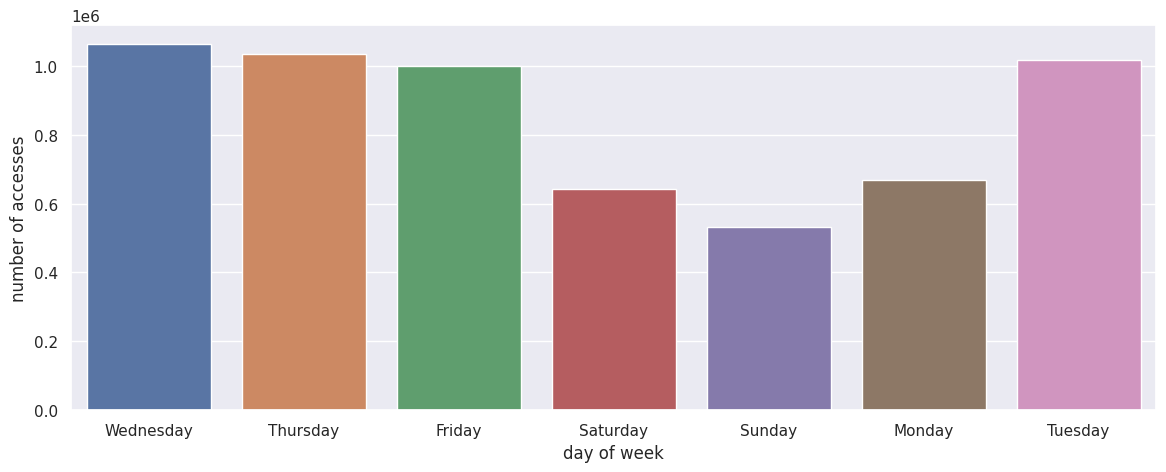

In [35]:
reading_by_day = reading_df.groupby(['date']).agg({"user_id": "count"}).reset_index().rename(columns={"user_id": "count"}).sort_values(by=['count'], ascending=False)
reading_by_day["dow"] = reading_by_day['date'].apply(lambda x: x.strftime('%A'))
reading_by_day = reading_by_day.sort_values(by=['date'], ascending=True)


sns.set(rc={'figure.figsize':(14,5)})

p = sns.barplot(data=reading_by_day, x='dow', y='count')
p.set(xlabel= "day of week", ylabel="number of accesses")
plt.show()

> **Suprisingly, people tend to read more in the middle of the week rather than
on weekends**

##### **What time of day do people read?**

In [36]:
reading_by_hour = reading_df.groupby(['hour']).agg({"user_id": "count"}).reset_index().rename(columns={"user_id": "count"}).sort_values(by=['count'], ascending=False)
reading_by_hour = reading_by_hour.sort_values(by=['hour'], ascending=True)
fig = px.line(reading_by_hour, x = 'hour', y = 'count')
fig.show()

> **There are 3 peaks: 8-9 o'clock, 14 o'clock and 20 o'clock that people tend to read more. The highest peak is at 14 o'clock**

##### **What kind of article do people read most?**

In [37]:
merged_table = reading_df.merge(articles_df, how = 'inner', on = 'article_id')
merged_table.head()

,user_id,article_id,event_time,date,hour,published_time,title,domain,category
0,13214459406561935989,14810025847983156880,2022-04-06 00:00:00,2022-04-06,0,2022-04-04 17:02:27,Mỹ nêu khả năng dỡ lệnh trừng phạt Nga,vnexpress.net,Tin thế giới
1,8891622829200356835,14810025847983156880,2022-04-06 00:06:28,2022-04-06,0,2022-04-04 17:02:27,Mỹ nêu khả năng dỡ lệnh trừng phạt Nga,vnexpress.net,Tin thế giới
2,17054397274494357227,14810025847983156880,2022-04-06 00:12:40,2022-04-06,0,2022-04-04 17:02:27,Mỹ nêu khả năng dỡ lệnh trừng phạt Nga,vnexpress.net,Tin thế giới
3,1620967089251743258,14810025847983156880,2022-04-06 00:16:15,2022-04-06,0,2022-04-04 17:02:27,Mỹ nêu khả năng dỡ lệnh trừng phạt Nga,vnexpress.net,Tin thế giới
4,2040936581226042914,14810025847983156880,2022-04-06 00:24:21,2022-04-06,0,2022-04-04 17:02:27,Mỹ nêu khả năng dỡ lệnh trừng phạt Nga,vnexpress.net,Tin thế giới


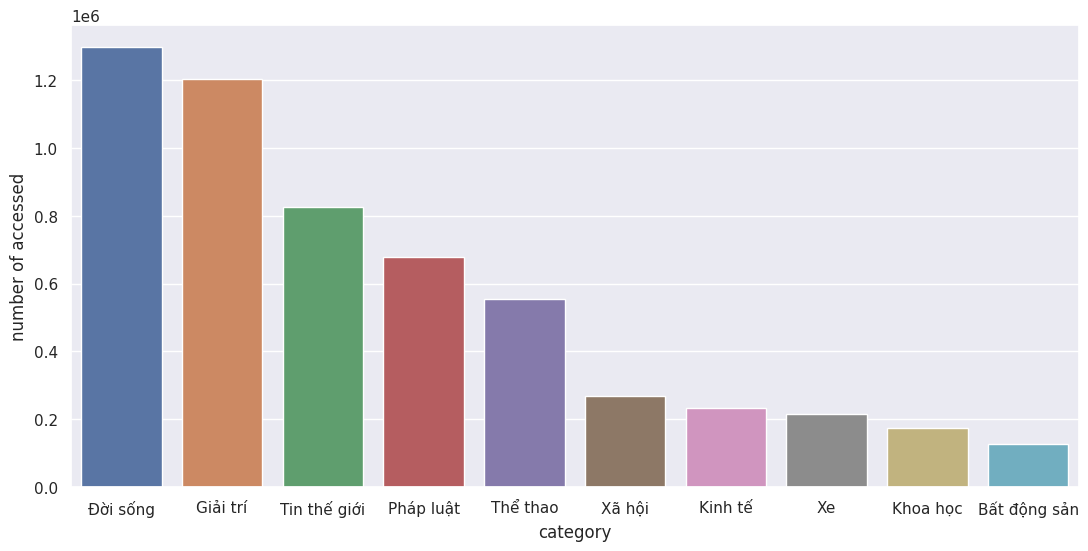

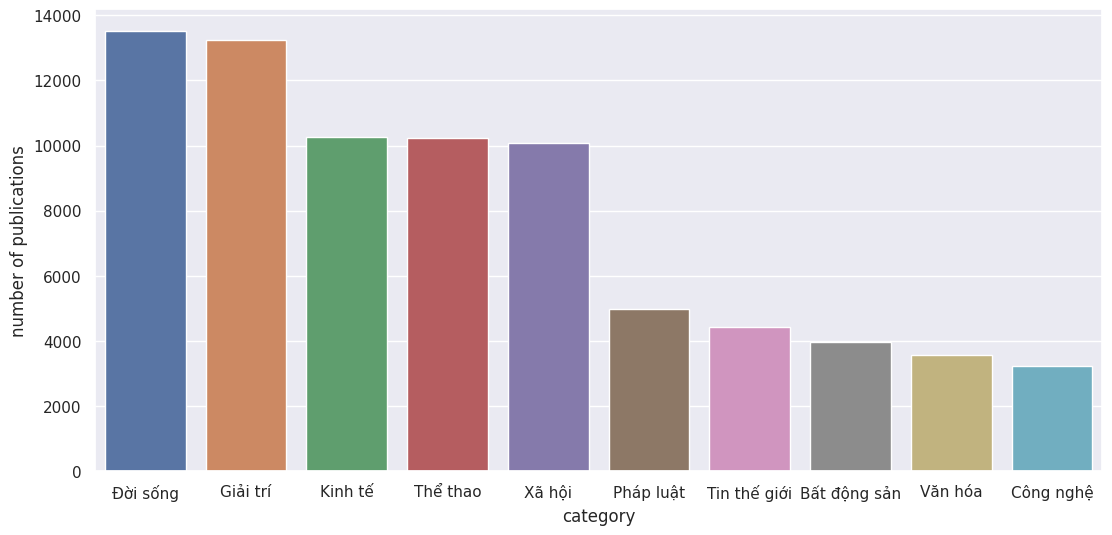

In [39]:
merged_table_cat = merged_table.groupby(['category']).agg({"article_id":"count"}).reset_index().rename(columns={"article_id": "count"}).sort_values(by=['count'], ascending=False)
sns.set(rc={'figure.figsize':(13,6)})

p = sns.barplot(data=merged_table_cat[:10], x='category', y='count')
p.set(xlabel= "category", ylabel="number of accessed")
plt.show()

sns.set(rc={'figure.figsize':(13,6)})

p = sns.barplot(data=cat_group[:10], x='category', y='count')
p.set(xlabel= "category", ylabel="number of publications")
plt.show()

> **Look again and compare between the number of published articles on each category and what people read most. Though in a group which has lowest number of publications, people read a lot about `Tin The Gioi`**

##### **Is there a difference between type of articles read by men and women**?

In [40]:
gender_merged_table = reading_df.merge(articles_df, how = 'inner', on = 'article_id').merge(users_df, how="inner", on = "user_id")
gender_merged_table.head()

,user_id,article_id,event_time,date,hour,published_time,title,domain,category,gender,age,os_name
0,13214459406561935989,14810025847983156880,2022-04-06 00:00:00,2022-04-06,0,2022-04-04 17:02:27,Mỹ nêu khả năng dỡ lệnh trừng phạt Nga,vnexpress.net,Tin thế giới,Male,55-64,windows
1,13214459406561935989,14912106567195011657,2022-04-06 08:14:45,2022-04-06,8,2022-04-05 20:02:32,Việt Nam lần đầu có 7 tỷ phú,zingnews.vn,Kinh tế,Male,55-64,windows
2,13214459406561935989,7814199118118063622,2022-04-06 14:40:41,2022-04-06,14,2022-04-04 13:15:44,Người đàn ông bắt được 'khủng long sống' khổng...,infonet.vietnamnet.vn,Khoa học,Male,55-64,windows
3,13214459406561935989,6014131710396465072,2022-04-06 23:16:16,2022-04-06,23,2022-04-05 07:10:45,"Quyết định mới của Tổng thống Putin đối với ""c...",baophapluat.vn,Tin thế giới,Male,55-64,windows
4,13214459406561935989,3321864857941615107,2022-04-06 15:01:46,2022-04-06,15,2022-04-04 14:41:45,Cô gái Việt kể lần đi ăn 'tiệc kín' ở Nhật Bản,zingnews.vn,Đời sống,Male,55-64,windows


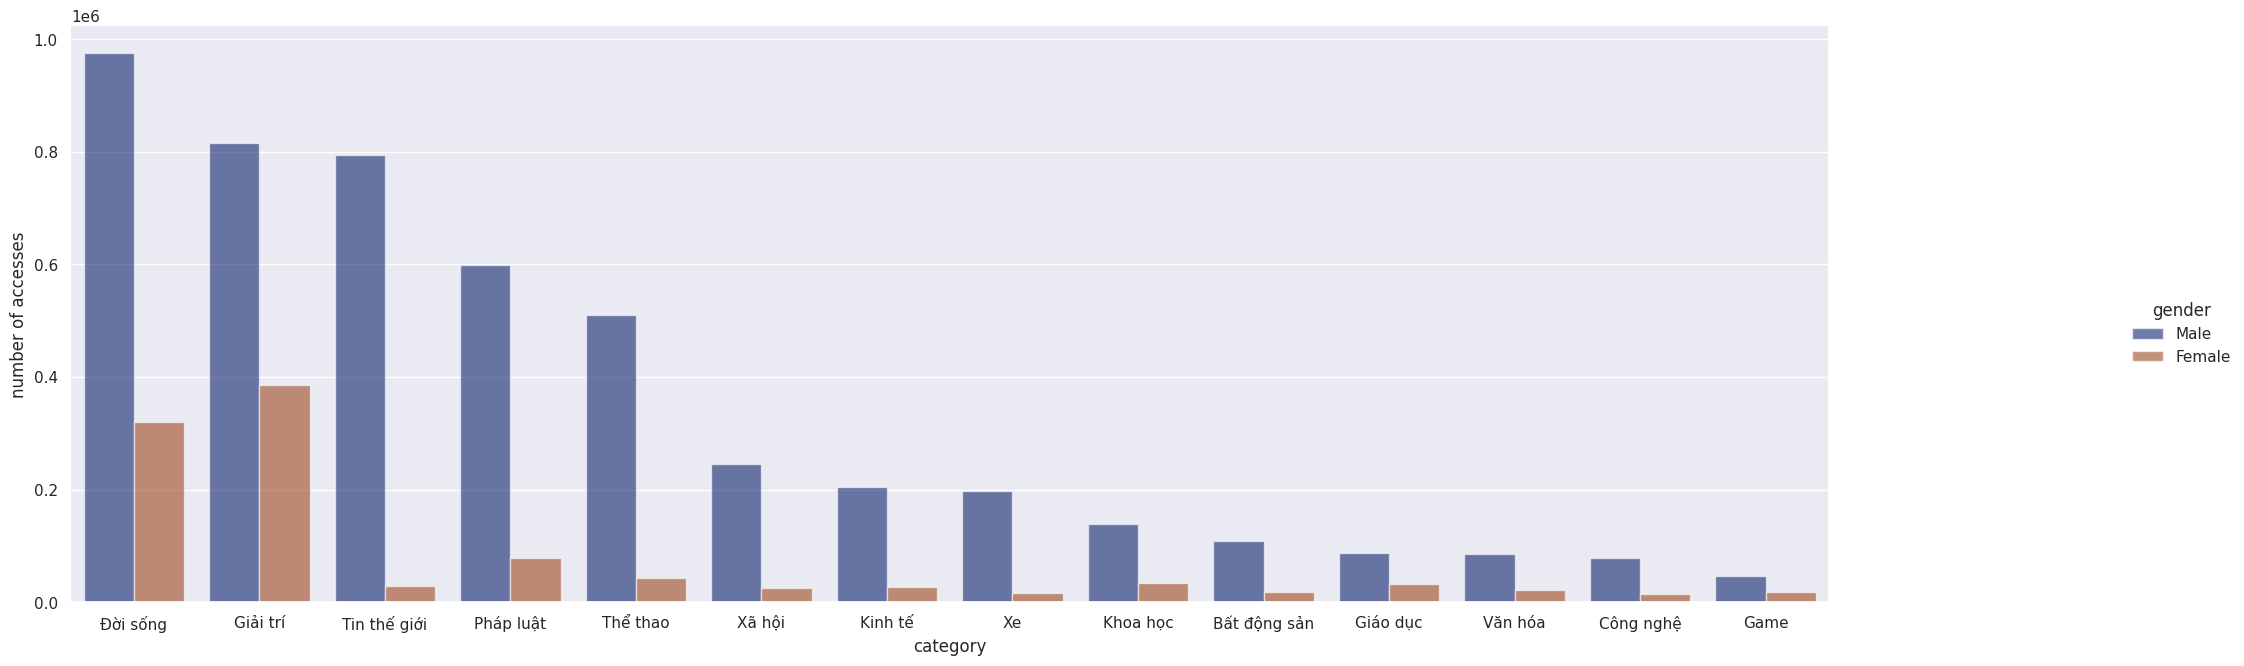

In [41]:
gender_reading_df = gender_merged_table.groupby(['gender','category']).agg({"article_id":"count"}).reset_index().rename(columns={"article_id": "count"}).sort_values(by=['count'], ascending=False)

g = sns.catplot(
    data=gender_reading_df, kind="bar",
    x="category", y="count", hue="gender",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("category", "number of accesses")
g.fig.set_figwidth(25)
g.fig.set_figheight(7)

> **`Giai Tri` is the category is read most by women, in the meanwhile, `Doi song` is the category read most by men**

##### **What do people care about?**

In [ ]:
titles = merged_table['title']
unique_title = list(set(titles))

unique_title_pos_dict = {}

for i, title in tqdm(enumerate(unique_title)):
    unique_title_pos_dict[title] = i

In [ ]:
tokens_title = {}

for title in tqdm(unique_title):
    tokens = word_tokenize(title)
    tokens_title[title] = tokens

In [ ]:
merged_table['tokens_title'] = merged_table['title'].apply(lambda x: tokens_title[x])
def combine_word(x: list):
    for i,item in enumerate(x):
        if ' ' in item:
            x[i] = x[i].replace(' ', '_')

    return x

merged_table['tokens_title'] = merged_table['tokens_title'].apply(lambda x: combine_word(x))

In [ ]:
stopwords = []
with open("vietnamese-stopwords.txt", "r") as f:
    stopwords = f.read().split('\n')

In [ ]:
corpus = []

for tokens_title in tqdm(merged_table['tokens_title']):
    for token in tokens_title:
        if token not in stopwords:
            corpus.append(token)

100%|██████████| 5956753/5956753 [14:56<00:00, 6647.71it/s] 


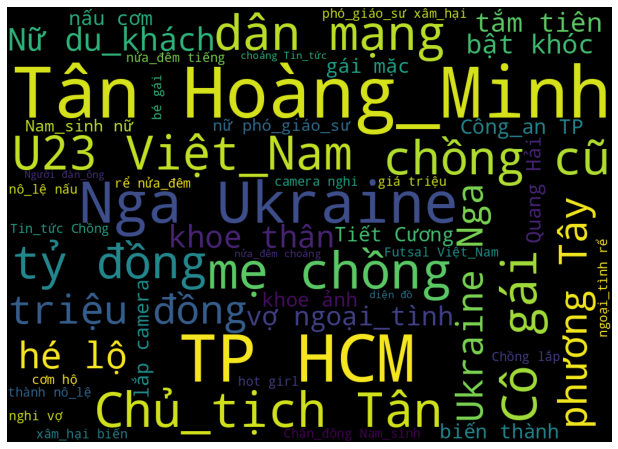

In [ ]:
NewNounString=' '.join(corpus)
wordcloudimage = WordCloud( max_words=50,
                            font_step=2 ,
                            max_font_size=500,
                            background_color='black',
                            width=1000,
                            height=720
                          ).generate(NewNounString)

plt.figure(figsize=(20,8))
plt.imshow(wordcloudimage)
plt.axis("off")
plt.show()

> **We can see that people care about some keywords "Tan Hoang Minh"; "Nga Ukraine" ; "phuong Tay";...**

### Article Recommendation

In [ ]:
users_df[users_df['user_id'] == 15099768449101904560]

,user_id,gender,age,os_name
10804,15099768449101904560,Male,18-24,windows


In [ ]:
users_df[users_df['user_id'] == 10905364777234019509]

,user_id,gender,age,os_name
26601,10905364777234019509,Female,35-44,windows


> I use a basic approach which based on content to build recommendation system, which means the system will recommend articles related to what users have read recently, e.g 10 most recent articles

> I use TF-IDF method to represent articles, in which I concat 3 fields: domain, category and title

> As the corpus is Vietnamese (there are words consisting of 2 syllables e.g: hoc sinh, co giao, etc) so I use a specialised tool for Vietnamese to tokenize sentence.

In [ ]:
def tokenizer(text):
    return word_tokenize(text)

In [ ]:
merged_table['context'] = merged_table['domain'] + ' ' + merged_table['category'] + ' ' + merged_table['title']
articles_df['context'] = articles_df['domain'] + ' ' + articles_df['category'] + ' ' + articles_df['title']
articles_df['published_date'] = articles_df['published_time'].apply(lambda x: x.date())

In [ ]:
class ContentBasedRecommender:

    def __init__(self, articles_df, user_reading_df, n_gram = (1,2), stop_words = None, tokenizer = None):
        """
        n_gram: the range of n-values for different n-grams to be extracted
        stop_words: list of stop words
        tokenizer: callable for tokenize string
        """
        self.user_reading_df = user_reading_df
        self.articles_df = articles_df

        self.vectorizer = TfidfVectorizer(lowercase = True,
                                          ngram_range = n_gram,
                                          stop_words = stop_words,
                                          tokenizer = tokenizer)

        self.vectorizer.fit(self.articles_df['context'])

    def recommend(self, user_id:int, date:str, time_lag_history = 10, topk=10):
        """

        """

        # get the newest reading history of user
        user_history = self.user_reading_df[(self.user_reading_df['date'] <= pd.to_datetime(date).date()) & (self.user_reading_df['user_id'] == user_id)].sort_values(by=['date'], ascending=False)[:time_lag_history]

        # only get newest news to recommend to user
        new_articles = self.articles_df[self.articles_df['published_date'] == pd.to_datetime(date).date()]

        # embed user's history articles and new published articles
        user_history_embeds = self.vectorizer.transform(user_history['context'])
        new_articles_embeds = self.vectorizer.transform(new_articles['context'])

        # calculate cosine similarity and get top k relevent articles to those user's history
        cosine_sims = linear_kernel(user_history_embeds, new_articles_embeds).flatten()
        related_articles_indices = cosine_sims.argsort()[:-topk*2:-1]
        related_articles_indices = related_articles_indices%new_articles_embeds.shape[0]
        d = []
        for i in related_articles_indices:
            if i not in d:
                d.append(i)
                if len(d) == topk:
                    break
        return new_articles.iloc[d]

In [ ]:
content_based_recommender = ContentBasedRecommender(articles_df, merged_table, stop_words = stopwords, tokenizer=tokenizer)

In [ ]:
content_based_recommender.recommend(user_id = 10905364777234019509, date = '2022-04-13')

,article_id,published_time,title,domain,category,context,date,published_date
52486,4019362314888452419,2022-04-13 18:00:10,Hôn nhân xa cách trước khi ly hôn của MC Hoàng...,zingnews.vn,Giải trí,zingnews.vn Giải trí Hôn nhân xa cách trước kh...,2022-04-13,2022-04-13
9028,9734346959679492715,2022-04-13 15:55:00,Chồng Tây của Hoàng Oanh có động thái gây chú ...,afamily.vn,Giải trí,afamily.vn Giải trí Chồng Tây của Hoàng Oanh c...,2022-04-13,2022-04-13
55247,5917653892154024255,2022-04-13 06:52:00,"1 ngày sau thông báo ly hôn MC Hoàng Oanh, chồ...",toquoc.vn,Giải trí,toquoc.vn Giải trí 1 ngày sau thông báo ly hôn...,2022-04-13,2022-04-13
33219,15843201616607914625,2022-04-13 10:07:42,"Sau khi chồng Tây tuyên bố ly hôn, Hoàng Oanh ...",saostar.vn,Giải trí,saostar.vn Giải trí Sau khi chồng Tây tuyên bố...,2022-04-13,2022-04-13
60426,4962018646559778050,2022-04-13 08:07:00,Hoàng Oanh và chồng Tây đang ở bên nhau dù thô...,afamily.vn,Giải trí,afamily.vn Giải trí Hoàng Oanh và chồng Tây đa...,2022-04-13,2022-04-13
39971,9390943038123744260,2022-04-13 10:36:00,Chồng MC Hoàng Oanh bất ngờ có động thái liên ...,phunutoday.vn,Đời sống,phunutoday.vn Đời sống Chồng MC Hoàng Oanh bất...,2022-04-13,2022-04-13
30410,14540756388741662991,2022-04-13 07:33:29,Tổng thống Ukraine Zelensky đề nghị trao đổi t...,vietnamplus.vn,Tin thế giới,vietnamplus.vn Tin thế giới Tổng thống Ukraine...,2022-04-13,2022-04-13
63605,6499508369415581682,2022-04-13 21:49:00,Động thái chồng Tây sau khi Hoàng Oanh xác nhậ...,kienthuc.net.vn,Giải trí,kienthuc.net.vn Giải trí Động thái chồng Tây s...,2022-04-13,2022-04-13
42895,15939974305467047188,2022-04-13 07:16:00,Chồng Tây tuyên bố ly hôn soi đường tình của g...,kienthuc.net.vn,Giải trí,kienthuc.net.vn Giải trí Chồng Tây tuyên bố ly...,2022-04-13,2022-04-13
21573,11955473236424027045,2022-04-13 11:59:26,Sốc trước trạng thái cảm xúc của MC Hoàng Oanh...,phunuvagiadinh.vn,Giải trí,phunuvagiadinh.vn Giải trí Sốc trước trạng thá...,2022-04-13,2022-04-13


In [ ]:
merged_table[merged_table['user_id'] == 10905364777234019509].sort_values(by=['date'], ascending=False)[:10][['title','domain', 'category']]

,title,domain,category
5825070,Hoàng Oanh nói gì 15 phút trước khi chồng tuyê...,phunuvietnam.vn,Giải trí
5576290,Đời không khuất phục của chàng trai bại não,vnexpress.net,Giáo dục
4934254,Tiếng súng oan nghiệt giữa mâm cơm khiến 7 ngư...,24h.com.vn,Pháp luật
5082640,"Làm phù dâu đám cưới anh trai, Harper Beckham ...",eva.vn,Giải trí
5251734,"Cung nữ trộm gối của Từ Hy Thái hậu, 64 năm sa...",doanhnghiepvn.vn,Văn hóa
5414349,Chồng Tây của Hoàng Oanh khoe khoảnh khắc gia ...,afamily.vn,Giải trí
5475351,Jack Cole thông báo ly hôn MC Hoàng Oanh,zingnews.vn,Giải trí
5475374,Jack Cole thông báo ly hôn MC Hoàng Oanh,zingnews.vn,Giải trí
5438684,Tổng thống Ukraine Zelensky nói về hậu quả nếu...,24h.com.vn,Tin thế giới
5725197,"Con gái 3 tuổi bị bắt cóc, được tìm thấy sau 1...",kenh14.vn,Đời sống


In [ ]:
content_based_recommender.recommend(user_id = 15099768449101904560, date = '2022-04-13')

,article_id,published_time,title,domain,category,context,date,published_date
27444,13931129045873067861,2022-04-13 17:43:01,Một ngân hàng Việt có thể lựa chọn chiến lược ...,theleader.vn,Kinh tế,theleader.vn Kinh tế Một ngân hàng Việt có thể...,2022-04-13,2022-04-13
22237,12563479539048888877,2022-04-13 21:30:00,Lý do Ấn Độ và Trung Quốc không xích lại gần nhau,24h.com.vn,Tin thế giới,24h.com.vn Tin thế giới Lý do Ấn Độ và Trung Q...,2022-04-13,2022-04-13
35550,1627972826479340212,2022-04-13 17:21:00,Giới siêu giàu ngày càng giàu nhờ “tích sản” v...,toquoc.vn,Bất động sản,toquoc.vn Bất động sản Giới siêu giàu ngày càn...,2022-04-13,2022-04-13
60818,5671160502843517782,2022-04-13 16:19:55,Giới siêu giàu càng giàu nhờ “tích sản” vào di...,vneconomy.vn,Bất động sản,vneconomy.vn Bất động sản Giới siêu giàu càng ...,2022-04-13,2022-04-13
22056,12399074122476838473,2022-04-13 12:00:00,Mặc trang phục dự đám cưới đẹp như vợ chồng Mi...,phunuvietnam.vn,Giải trí,phunuvietnam.vn Giải trí Mặc trang phục dự đám...,2022-04-13,2022-04-13
40487,12813182687666497000,2022-04-13 16:15:00,Mặc gợi cảm khoe dáng bên siêu xe hot girl gây...,kienthuc.net.vn,Giải trí,kienthuc.net.vn Giải trí Mặc gợi cảm khoe dáng...,2022-04-13,2022-04-13
56736,7224798834842229183,2022-04-13 15:26:00,"Bù đắp kiến thức, kỹ năng cho học sinh tiểu học",phunuvietnam.vn,Giáo dục,"phunuvietnam.vn Giáo dục Bù đắp kiến thức, kỹ ...",2022-04-13,2022-04-13
13641,11232947848296467823,2022-04-13 21:35:00,Sinh viên báo chí học làm nghề tại Hội Báo toà...,phunuvietnam.vn,Giáo dục,phunuvietnam.vn Giáo dục Sinh viên báo chí học...,2022-04-13,2022-04-13
56938,7398537015864457411,2022-04-13 09:20:05,Giới trẻ sáng tạo như thế nào?,zingnews.vn,Giải trí,zingnews.vn Giải trí Giới trẻ sáng tạo như thế...,2022-04-13,2022-04-13
68636,15032110434392546838,2022-04-13 12:24:00,Trường mầm non xây dựng kịch bản ứng phó dịch ...,phunuvietnam.vn,Giáo dục,phunuvietnam.vn Giáo dục Trường mầm non xây dự...,2022-04-13,2022-04-13


In [ ]:
merged_table[merged_table['user_id'] == 15099768449101904560].sort_values(by=['date'], ascending=False)[:10][['title','domain', 'category']]

,title,domain,category
5454087,"Mặc trang phục truyền thống gợi cảm nhất, bóng...",24h.com.vn,Giải trí
4662983,Vượt khó bằng suy nghĩ tích cực,phunuvietnam.vn,Giáo dục
5021684,"Đến đón dâu, chú rể tái mét mặt, hoảng loạn kh...",tintuc.vn,Đời sống
4917280,"7 thứ vô bổ người giàu ít khi rút hầu bao, ngư...",eva.vn,Đời sống
4731378,Vai diễn trong mơ của các diễn viên,zingnews.vn,Giải trí
4448032,"""Em gái BTS"" dính phốt bạo lực học đường liên ...",toquoc.vn,Giải trí
4603661,"Ngây ngất trước cosplay Ngu Cơ, mỹ nhân của Hạ...",vietgiaitri.com,Game
4664078,Ấn Độ: Băng trộm dùng thủ đoạn kỳ lạ lấy đi cả...,24h.com.vn,Tin thế giới
4666750,"Sợ đám đông có thể học Luật, Ngoại giao được k...",vnexpress.net,Giáo dục
4694594,Trang phục làm nên đẳng cấp cho giới siêu giàu,zingnews.vn,Giải trí


> There are more approaches for this problem which focus on personalizing users to improve the user engagement but in this assignment I chose the basic one as the baseline approach.